# Chapter 5.3~ 次元削減2

In [47]:
from IPython.display import Image
%matplotlib inline

Wineデータをダウンロードして、少し表示してみる

In [48]:
import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines', 'Proline']
num_classes = 13
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


データの標準化を行う

In [49]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

# X(features): [[14.23, 1.71, 2.43, ...], ...]
# y(labels): [1, 1, ...]
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

# 訓練データ70%, テストデータ30%に分離する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 標準化
sc = StandardScaler()
X_std = sc.fit_transform(X)
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

データをplotする関数の定義

In [50]:
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def wine_plot3d(x, y, title="", plt=plt):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[y == 1, 0], x[y == 1, 1], x[y == 1, 2], color='red', marker='o', alpha=0.5)
    ax.scatter(x[y == 2, 0], x[y == 2, 1], x[y == 2, 2], color='blue', marker='o', alpha=0.5)
    ax.scatter(x[y == 3, 0], x[y == 3, 1], x[y == 3, 2], color='green', marker='o', alpha=0.5)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.title(title)
    plt.show()
    
def wine_plot2d(x, y, title=""):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(x[y==1, 0], x[y==1, 1], 
            color='red', marker='o', alpha=0.5)
    ax.scatter(x[y==2, 0], x[y==2, 1],
                color='blue', marker='o', alpha=0.5)
    ax.scatter(x[y==3, 0], x[y==3, 1],
                color='green', marker='o', alpha=0.5)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    plt.tight_layout()
    # plt.savefig('./figures/half_moon_3.png', dpi=300)
    plt.title(title)
    plt.show()

# kernel PCA

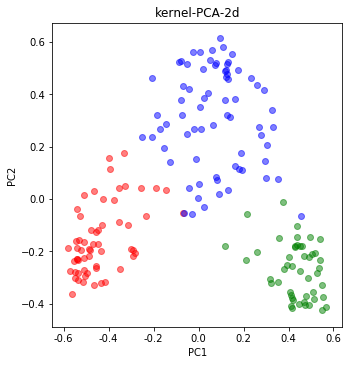

In [51]:
from sklearn.decomposition import KernelPCA
KPCA2 = KernelPCA(n_components=2, kernel="rbf")
X_kpca2 = KPCA2.fit_transform(X_std)
wine_plot2d(X_kpca2, y, title="kernel-PCA-2d")

# KPCA3 = KernelPCA(n_components=3, kernel="rbf")
# X_kpca3 = KPCA3.fit_transform(X_std)
# wine_plot3d(X_kpca3, y, title="kernel-PCA-3D")

kernel PCAで1次元から12次元の各次元へ次元削減してロジスティック回帰で学習・評価

In [52]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression

kpca_list = [KernelPCA(n_components=i+1, kernel="rbf") for i in range(num_classes-1)]

# 1次元〜(num_classes-1)次元まで削減した各々のデータを格納
X_kpca_train = [kpca_list[i].fit_transform(X_train_std) for i in range(num_classes - 1)]
X_kpca_test = [kpca_list[i].transform(X_test_std) for i in range(num_classes -1)]

kpca_train_score, kpca_test_score = [], []
lr = LogisticRegression()
for i in range(num_classes-1):
    lr = lr.fit(X_kpca_train[i], y_train)
    kpca_train_score.append(lr.score(X_kpca_train[i], y_train))
    kpca_test_score.append(lr.score(X_kpca_test[i], y_test))
    
for i in range(num_classes-1):
    print("dim:{}\tscore:{:.5f}\ttrain_score:{:.5f}".format(i+1, kpca_test_score[i], kpca_train_score[i]))

dim:1	score:0.85185	train_score:0.88710
dim:2	score:1.00000	train_score:0.96774
dim:3	score:1.00000	train_score:0.97581
dim:4	score:1.00000	train_score:0.98387
dim:5	score:1.00000	train_score:0.97581
dim:6	score:1.00000	train_score:0.98387
dim:7	score:1.00000	train_score:0.98387
dim:8	score:1.00000	train_score:0.98387
dim:9	score:1.00000	train_score:0.98387
dim:10	score:1.00000	train_score:0.98387
dim:11	score:1.00000	train_score:0.98387
dim:12	score:1.00000	train_score:0.98387


# Locally Linear Embedding(LLE)

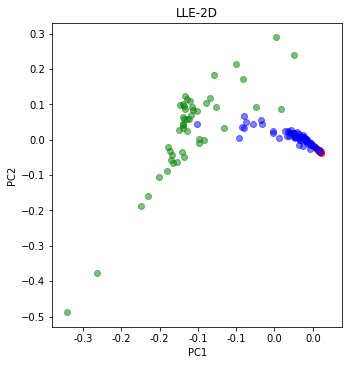

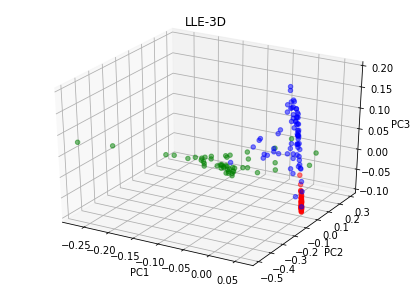

In [53]:
from sklearn.manifold import LocallyLinearEmbedding
LLE2 = LocallyLinearEmbedding(n_components=2)
X_lle2 = LLE2.fit_transform(X_std)
wine_plot2d(X_lle2, y, title="LLE-2D")

LLE3 = LocallyLinearEmbedding(n_components=3)
X_lle3 = LLE3.fit_transform(X_std)
wine_plot3d(X_lle3, y, title="LLE-3D")

LLEで1次元から12次元の各次元へ次元削減してロジスティック回帰で学習・評価

In [54]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import LogisticRegression

lle_list = [LocallyLinearEmbedding(n_components=i+1) for i in range(num_classes-1)]

# 1次元〜(num_classes-1)次元まで削減した各々のデータを格納
X_lle_train = [lle_list[i].fit_transform(X_train_std) for i in range(num_classes - 1)]
X_lle_test = [lle_list[i].transform(X_test_std) for i in range(num_classes -1)]

lle_train_score, lle_test_score = [], []
lr = LogisticRegression()
for i in range(num_classes-1):
    lr = lr.fit(X_lle_train[i], y_train)
    lle_train_score.append(lr.score(X_lle_train[i], y_train))
    lle_test_score.append(lr.score(X_lle_test[i], y_test))
    
for i in range(num_classes-1):
    print("dim:{}\tscore:{:.5f}\ttrain_score:{:.5f}".format(i+1, lle_test_score[i], lle_train_score[i]))

dim:1	score:0.64815	train_score:0.66129
dim:2	score:0.96296	train_score:0.91935
dim:3	score:0.98148	train_score:0.92742
dim:4	score:0.98148	train_score:0.93548
dim:5	score:0.98148	train_score:0.93548
dim:6	score:0.98148	train_score:0.93548
dim:7	score:0.98148	train_score:0.93548
dim:8	score:0.98148	train_score:0.93548
dim:9	score:0.98148	train_score:0.93548
dim:10	score:1.00000	train_score:0.93548
dim:11	score:1.00000	train_score:0.94355
dim:12	score:1.00000	train_score:0.94355


# Multi-Dimensional Scaling

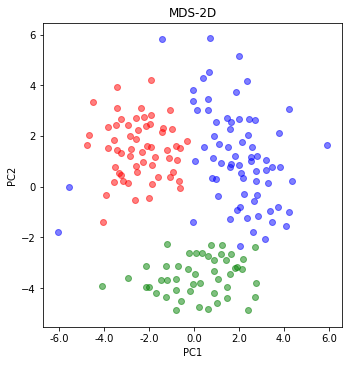

In [55]:
from sklearn.manifold import MDS

MDS2 = MDS(n_components=2)
X_mds2 = MDS2.fit_transform(X_std)
wine_plot2d(X_mds2, y, title="MDS-2D")

# MDS3 = MDS(n_components=3)
# wine_plot3d(X_mds3, y, title="MDS-3D")
# X_mds3 = MDS3.fit_transform(X_std)

MDSは何故かtransformメソッドを持たないため、テストの評価は不能

In [56]:
from sklearn.manifold import MDS
from sklearn.linear_model import LogisticRegression

mds_list = [MDS(n_components=i+1) for i in range(num_classes-1)]

# 1次元〜(num_classes-1)次元まで削減した各々のデータを格納
X_mds_train = [mds_list[i].fit_transform(X_train_std) for i in range(num_classes - 1)]

mds_train_score, mds_test_score = [], []
lr = LogisticRegression()
for i in range(num_classes-1):
    lr = lr.fit(X_mds_train[i], y_train)
    mds_train_score.append(lr.score(X_mds_train[i], y_train))
    
for i in range(num_classes-1):
    print("dim:{}\tmds_train_score:{:.5f}".format(i+1, mds_train_score[i]))

dim:1	mds_train_score:0.87097
dim:2	mds_train_score:0.93548
dim:3	mds_train_score:0.94355
dim:4	mds_train_score:0.97581
dim:5	mds_train_score:0.99194
dim:6	mds_train_score:0.98387
dim:7	mds_train_score:0.98387
dim:8	mds_train_score:0.98387
dim:9	mds_train_score:0.99194
dim:10	mds_train_score:0.99194
dim:11	mds_train_score:0.99194
dim:12	mds_train_score:0.99194


# Isomap

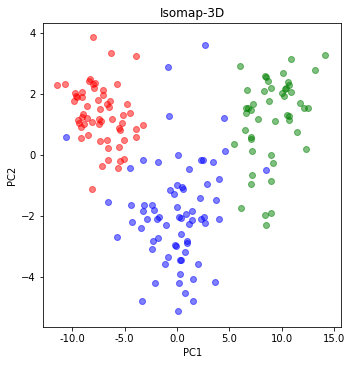

In [57]:
from sklearn.manifold import Isomap

ism2 = Isomap(n_components=2)
X_ism2 = ism2.fit_transform(X_std)
wine_plot2d(X_ism2, y, title="Isomap-3D")

# ism3 = Isomap(n_components=3)
# X_ism3 = ism3.fit_transform(X_std)
# wine_plot3d(X_ism3, y, title="Isomap-2D")

Isomapで1次元から12次元の各次元へ次元削減してロジスティック回帰で学習・評価

In [58]:
from sklearn.manifold import Isomap

from sklearn.linear_model import LogisticRegression

ism_list = [Isomap(n_components=i+1) for i in range(num_classes-1)]

# 1次元〜(num_classes-1)次元まで削減した各々のデータを格納
X_ism_train = [ism_list[i].fit_transform(X_train_std) for i in range(num_classes - 1)]
X_ism_test = [ism_list[i].transform(X_test_std) for i in range(num_classes -1)]

ism_train_score, ism_test_score = [], []
for i in range(num_classes-1):
    lr = LogisticRegression()
    lr = lr.fit(X_ism_train[i], y_train)
    ism_train_score.append(lr.score(X_ism_train[i], y_train))
    ism_test_score.append(lr.score(X_ism_test[i], y_test))
    
for i in range(num_classes-1):
    print("dim:{}\tscore:{:.5f}\tism_train_score:{:.5f}".format(i+1, ism_test_score[i], ism_train_score[i]))

dim:1	score:0.90741	ism_train_score:0.92742
dim:2	score:0.92593	ism_train_score:0.90323
dim:3	score:0.96296	ism_train_score:0.93548
dim:4	score:0.96296	ism_train_score:0.93548
dim:5	score:0.96296	ism_train_score:0.93548
dim:6	score:0.94444	ism_train_score:0.93548
dim:7	score:0.94444	ism_train_score:0.96774
dim:8	score:0.94444	ism_train_score:0.95968
dim:9	score:0.94444	ism_train_score:0.95968
dim:10	score:0.94444	ism_train_score:0.95968
dim:11	score:0.92593	ism_train_score:0.95968
dim:12	score:0.94444	ism_train_score:0.95968


Baselineとして：適当に次元削減した場合

sampled dimension: [2, 10]


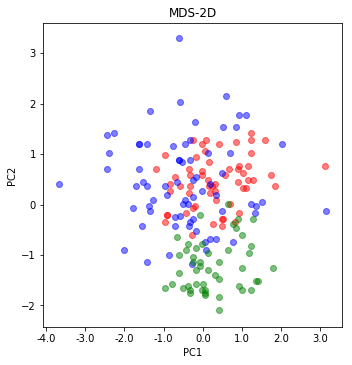

In [59]:
import random
sample_dimensions = [i for i in range(num_classes)]
random.shuffle(sample_dimensions)
print("sampled dimension:", sample_dimensions[:2])
wine_plot2d(X_std[:,sample_dimensions[:2]], y, title="MDS-2D")

In [60]:
from sklearn.linear_model import LogisticRegression

# 1次元〜(num_classes-1)次元まで削減した各々のデータを格納
X_rand_train = [X_train_std[:,sample_dimensions[:i+1]] for i in range(num_classes - 1)]
X_rand_test = [X_test_std[:, sample_dimensions[:i+1]] for i in range(num_classes - 1)]

rand_train_score, rand_test_score = [], []
lr = LogisticRegression()
for i in range(num_classes-1):
    lr = lr.fit(X_rand_train[i], y_train)
    rand_train_score.append(lr.score(X_rand_train[i], y_train))
    rand_test_score.append(lr.score(X_rand_test[i], y_test))
    
for i in range(num_classes-1):
    print("dim:{}\trand_train_score:{:.5f}\trand_test_score:{:.5f}\tsampled_dim:{}".format(
            i+1, rand_train_score[i], rand_test_score[i], sample_dimensions[:i+1])
         )

dim:1	rand_train_score:0.41129	rand_test_score:0.61111	sampled_dim:[2]
dim:2	rand_train_score:0.62097	rand_test_score:0.74074	sampled_dim:[2, 10]
dim:3	rand_train_score:0.86290	rand_test_score:0.79630	sampled_dim:[2, 10, 3]
dim:4	rand_train_score:0.87097	rand_test_score:0.87037	sampled_dim:[2, 10, 3, 7]
dim:5	rand_train_score:0.91935	rand_test_score:0.94444	sampled_dim:[2, 10, 3, 7, 9]
dim:6	rand_train_score:0.95968	rand_test_score:0.88889	sampled_dim:[2, 10, 3, 7, 9, 6]
dim:7	rand_train_score:0.95968	rand_test_score:0.90741	sampled_dim:[2, 10, 3, 7, 9, 6, 5]
dim:8	rand_train_score:0.95161	rand_test_score:0.90741	sampled_dim:[2, 10, 3, 7, 9, 6, 5, 11]
dim:9	rand_train_score:0.95968	rand_test_score:0.90741	sampled_dim:[2, 10, 3, 7, 9, 6, 5, 11, 4]
dim:10	rand_train_score:1.00000	rand_test_score:0.98148	sampled_dim:[2, 10, 3, 7, 9, 6, 5, 11, 4, 12]
dim:11	rand_train_score:0.99194	rand_test_score:1.00000	sampled_dim:[2, 10, 3, 7, 9, 6, 5, 11, 4, 12, 1]
dim:12	rand_train_score:0.99194	rand

# まとめ

kernel-PCA LLE, MDS, Isomapの各種法により次元削減を行い、Logistic Regressionで学習して評価・比較

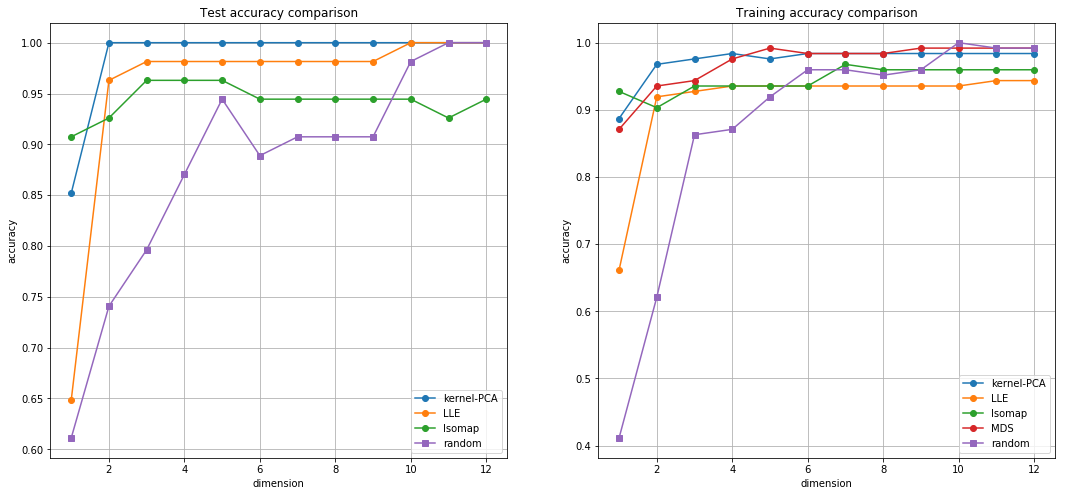

In [70]:
dimensions = [i+1 for i in range(num_classes-1)]

fig, (axL, axR) = plt.subplots(ncols=2, figsize=(18,8))

# 左の図についてグラフ描画
plt_kpca_l = axL.plot(dimensions, kpca_test_score, color="C0", marker="o")
plt_lle_l = axL.plot(dimensions, lle_test_score, color="C1", marker="o")
plt_ism_l = axL.plot(dimensions, ism_test_score, color="C2", marker="o")
plt_rand_l = axL.plot(dimensions, rand_test_score, color="C4", marker="s")
axL.grid(True)
axL.set_xlabel("dimension")
axL.set_ylabel("accuracy")
axL.set_title("Test accuracy comparison")
hoge = axL.legend((plt_kpca_l[0], plt_lle_l[0], plt_ism_l[0], plt_rand_l[0]), ("kernel-PCA", "LLE", "Isomap", "random"))

# 右の図についてグラフ描画
plt_kpca_r = axR.plot(dimensions, kpca_train_score, color="C0", marker="o")
plt_lle_r = axR.plot(dimensions, lle_train_score, color="C1", marker="o")
plt_ism_r = axR.plot(dimensions, ism_train_score, color="C2", marker="o")
plt_mds_r = axR.plot(dimensions, mds_train_score, color="C3", marker="o")
plt_rand_r = axR.plot(dimensions, rand_train_score, color="C4", marker="s")
axR.grid(True)
axR.set_xlabel("dimension")
axR.set_ylabel("accuracy")
axR.set_title("Training accuracy comparison")
hoge = axR.legend((plt_kpca_r[0], plt_lle_r[0], plt_ism_r[0], plt_mds_r[0], plt_rand_r[0]), ("kernel-PCA", "LLE", "Isomap", "MDS", "random"))